In [1]:
import pandas as pd
from src.train import *
from src.model import CNNLSTMModel
from src.dataset import *
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [2]:
performe_visualization = False

In [3]:
# some important parameters
pre_day = 5

feature_cols = [
    "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    "metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED",                  # DC voltage
    "metric.AC_POWER.MEASURED",                     # AC power
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')], # anomalies in the data
]

## Data Preprocessing


### Load Data

In [4]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions_w_maintenance.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [5]:
len(inverter_data.columns)

59

In [6]:
visualize_failure_timeline(failure_sessions)

In [7]:
if performe_visualization:
    # Visualize the raw data
    visualize_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

In [8]:
# remove unused columns
filtered_data = inverter_data[['event_local_time', 'device_name'] + feature_cols].copy()

### Anomoly Detection

In [9]:
if "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED" in filtered_data.columns:
    anomaly_ids = filtered_data["metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"]>=100
    filtered_data.loc[anomaly_ids, "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"] = None
    print("Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed:", anomaly_ids.sum())

Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed: 244163


### Missing Value Imputation

In [10]:
imputed_df = missing_value_imputation(
    filtered_data, feature_cols, 
    time_col='event_local_time', 
    device_col='device_name', 
    short_gap_limit=0, 
    long_fill_value=0.0, 
    add_missing_mask=True
    )
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

### Downsampling

In [11]:
downsampled_data = downsample_inverter_raw(imputed_df, drop_empty_bins=False)
downsampled_data.dropna(inplace=True) # NaN will be generated by downsampling, so we drop them

Downsampling 6126272 rows using following method: 
                                               Column Aggregation
0                       metric.AC_VOLTAGE_AB.MEASURED        mean
1                       metric.AC_VOLTAGE_BC.MEASURED        mean
2                       metric.AC_VOLTAGE_CA.MEASURED        mean
3                          metric.DC_VOLTAGE.MEASURED        mean
4                            metric.AC_POWER.MEASURED        mean
5               metric.AC_VOLTAGE_AB.MEASURED_missing        mean
6               metric.AC_VOLTAGE_BC.MEASURED_missing        mean
7               metric.AC_VOLTAGE_CA.MEASURED_missing        mean
8                  metric.DC_VOLTAGE.MEASURED_missing        mean
9                    metric.AC_POWER.MEASURED_missing        mean
10       metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED         max
11               metric.STATUS_INTERNAL_TEMP.MEASURED         max
12  metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_m...        mean
13       metric.STATUS_IN

In [12]:
if performe_visualization:
    # Visualize the downsampled data
    visualize_mean_values(
        downsampled_data, 
        failure_sessions, 
        extended_feature_cols, 
        'visualization', 
        'downsampled_data',
        freq=None
    )

### Data Cleaning

In [13]:
print("failure_sessions shape:", failure_sessions.shape)
failure_sessions['event_local_time'] = failure_sessions['start_time']
filtered_sessions = exclude_periods_from_data(failure_sessions, exclude_periods)
filtered_sessions['event_local_time'] = filtered_sessions['end_time']
filtered_sessions = exclude_periods_from_data(filtered_sessions, exclude_periods)
print("failure_sessions shape:", filtered_sessions .shape)

failure_sessions shape: (61, 6)
Excluded 2 periods, remaining data size: 47
Excluded 2 periods, remaining data size: 47
failure_sessions shape: (47, 7)


In [14]:
visualize_failure_timeline(filtered_sessions)

In [15]:
print("inverter_data shape:", downsampled_data.shape)
downsampled_data = exclude_periods_from_data(downsampled_data, exclude_periods)
print("Excluded data shape:", downsampled_data.shape)

inverter_data shape: (1021056, 16)
Excluded 2 periods, remaining data size: 862112
Excluded data shape: (862112, 16)


### Data Labeling

In [16]:
downsampled_data = prepare_dataset(downsampled_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 6064
Total rows: 837811


### Feature Engineering

In [17]:
# month_of_year 範圍 1~12
downsampled_data['month_sin'] = np.sin(2 * np.pi * downsampled_data['event_local_time'].dt.month / 12)
downsampled_data['month_cos'] = np.cos(2 * np.pi * downsampled_data['event_local_time'].dt.month / 12)

# 如果還有 hour_of_day (0~23) 也可以同理轉
downsampled_data['hour_sin'] = np.sin(2 * np.pi * downsampled_data['event_local_time'].dt.hour / 24)
downsampled_data['hour_cos'] = np.cos(2 * np.pi * downsampled_data['event_local_time'].dt.hour / 24)

extended_feature_cols += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']

In [18]:
v = downsampled_data[['metric.AC_VOLTAGE_AB.MEASURED','metric.AC_VOLTAGE_BC.MEASURED','metric.AC_VOLTAGE_CA.MEASURED']]
v_mean = v.mean(axis=1)
v_range = v.max(axis=1) - v.min(axis=1)
downsampled_data['V_mean'] = v_mean
downsampled_data['V_unbalance'] = v_range / (v_mean + 1e-6)

extended_feature_cols += ['V_mean', 'V_unbalance']

In [19]:
downsampled_data

,event_local_time,device_name,metric.AC_VOLTAGE_AB.MEASURED,metric.AC_VOLTAGE_BC.MEASURED,metric.AC_VOLTAGE_CA.MEASURED,metric.DC_VOLTAGE.MEASURED,metric.AC_POWER.MEASURED,metric.AC_VOLTAGE_AB.MEASURED_missing,metric.AC_VOLTAGE_BC.MEASURED_missing,metric.AC_VOLTAGE_CA.MEASURED_missing,...,metric.STATUS_INTERNAL_TEMP.MEASURED,metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_missing,metric.STATUS_INTERNAL_TEMP.MEASURED_missing,label,month_sin,month_cos,hour_sin,hour_cos,V_mean,V_unbalance
0,2021-12-24 00:00:00,INV 51,34400.171875,34400.000000,34400.000000,12.439572,0.0,0.0,0.0,0.0,...,40.000000,0.0,0.0,0,-2.449294e-16,1.000000,0.000000,1.000000,34400.058594,0.000005
1,2021-12-24 00:30:00,INV 51,34186.058594,34185.386719,34185.386719,41.699497,0.0,0.0,0.0,0.0,...,40.000000,0.0,0.0,0,-2.449294e-16,1.000000,0.000000,1.000000,34185.609375,0.000020
2,2021-12-24 01:00:00,INV 51,34186.824219,34186.449219,34186.449219,3.771897,0.0,0.0,0.0,0.0,...,41.000000,0.0,0.0,0,-2.449294e-16,1.000000,0.258819,0.965926,34186.574219,0.000011
3,2021-12-24 01:30:00,INV 51,34367.199219,34367.480469,34367.480469,4.273490,0.0,0.0,0.0,0.0,...,42.000000,0.0,0.0,0,-2.449294e-16,1.000000,0.258819,0.965926,34367.386719,0.000008
4,2021-12-24 02:00:00,INV 51,34101.886719,34101.933594,34101.933594,29.879051,0.0,0.0,0.0,0.0,...,42.036221,0.0,0.0,0,-2.449294e-16,1.000000,0.500000,0.866025,34101.917969,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837806,2025-07-23 21:30:00,INV 66,34283.332031,34283.332031,34283.332031,2.183333,0.0,0.0,0.0,0.0,...,44.000000,0.0,0.0,0,-5.000000e-01,-0.866025,-0.707107,0.707107,34283.332031,0.000000
837807,2025-07-23 22:00:00,INV 66,34200.000000,34200.000000,34200.000000,2.037213,0.0,0.0,0.0,0.0,...,43.000000,0.0,0.0,0,-5.000000e-01,-0.866025,-0.500000,0.866025,34200.000000,0.000000
837808,2025-07-23 22:30:00,INV 66,34300.746094,34300.746094,34300.746094,2.100000,0.0,0.0,0.0,0.0,...,41.000000,0.0,0.0,0,-5.000000e-01,-0.866025,-0.500000,0.866025,34300.746094,0.000000
837809,2025-07-23 23:00:00,INV 66,34516.667969,34516.667969,34516.667969,2.263698,0.0,0.0,0.0,0.0,...,40.000000,0.0,0.0,0,-5.000000e-01,-0.866025,-0.258819,0.965926,34516.667969,0.000000


In [20]:
downsampled_data['T_delta'] = downsampled_data['metric.STATUS_INTERNAL_TEMP.MEASURED'] - downsampled_data['metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED']
extended_feature_cols += ['T_delta']

In [21]:
if performe_visualization:
    visualize_mean_values(downsampled_data, failure_sessions, extended_feature_cols+['label'], 
                                title='processed_data', freq=None)

### Split Dataset

In [22]:
split_time = [pd.Timestamp('2024-06-30'), pd.Timestamp('2025-01-01')]


train_df = downsampled_data[downsampled_data['event_local_time'] <= split_time[0]].copy()
val_df = downsampled_data[(downsampled_data['event_local_time'] > split_time[0]) & (downsampled_data['event_local_time'] <= split_time[1])].copy()
test_df = downsampled_data[downsampled_data['event_local_time'] > split_time[1]].copy()

In [23]:
print('train set period:', train_df['event_local_time'].min(), train_df['event_local_time'].max())
print('validation set period:', val_df['event_local_time'].min(), val_df['event_local_time'].max())
print('test set period:', test_df['event_local_time'].min(), test_df['event_local_time'].max())

train set period: 2021-12-24 00:00:00 2024-06-30 00:00:00
validation set period: 2024-06-30 00:30:00 2025-01-01 00:00:00
test set period: 2025-01-01 00:30:00 2025-07-23 23:30:00


In [24]:
extended_feature_cols

['metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED',
 'metric.STATUS_INTERNAL_TEMP.MEASURED',
 'metric.AC_VOLTAGE_AB.MEASURED',
 'metric.AC_VOLTAGE_BC.MEASURED',
 'metric.AC_VOLTAGE_CA.MEASURED',
 'metric.DC_VOLTAGE.MEASURED',
 'metric.AC_POWER.MEASURED',
 'metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_missing',
 'metric.STATUS_INTERNAL_TEMP.MEASURED_missing',
 'metric.AC_VOLTAGE_AB.MEASURED_missing',
 'metric.AC_VOLTAGE_BC.MEASURED_missing',
 'metric.AC_VOLTAGE_CA.MEASURED_missing',
 'metric.DC_VOLTAGE.MEASURED_missing',
 'metric.AC_POWER.MEASURED_missing',
 'hour_sin',
 'hour_cos',
 'month_sin',
 'month_cos',
 'V_mean',
 'V_unbalance',
 'T_delta']

### Standardization

In [25]:
from scipy.stats import f_oneway

def anova_test(df, feature, device_col='device_name'):
    groups = [df[df[device_col] == d][feature].dropna() 
              for d in df[device_col].unique()]
    stat, p = f_oneway(*groups)
    return stat, p
anova_results = {col: anova_test(train_df, col) for col in extended_feature_cols}

In [26]:
anova_results_df = pd.DataFrame(anova_results, index=['F-statistic', 'p-value']).T
anova_results_df.sort_values(by='p-value', inplace=True)
anova_results_df

,F-statistic,p-value
metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED,174.303705,0.000000e+00
metric.DC_VOLTAGE.MEASURED,6949.560270,0.000000e+00
T_delta,477.546063,0.000000e+00
metric.STATUS_INTERNAL_TEMP.MEASURED,215.604605,0.000000e+00
month_sin,47.990752,1.360839e-143
metric.AC_VOLTAGE_AB.MEASURED,33.691740,4.599680e-98
V_mean,33.688267,4.717819e-98
metric.AC_VOLTAGE_CA.MEASURED,33.687260,4.752634e-98
metric.AC_VOLTAGE_BC.MEASURED,33.685768,4.804673e-98
metric.AC_POWER.MEASURED_missing,20.381119,3.765654e-56


In [27]:
import pandas as pd

def check_device_wise_stats(df, feature_cols, device_col='device_name'):
    stats = df.groupby(device_col)[feature_cols].agg(['mean', 'std'])
    return stats

check_device_wise_stats(downsampled_data, extended_feature_cols, device_col='device_name')

metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED             \
                                                    mean        std   
device_name                                                           
INV 51                                         28.366035  11.020061   
INV 52                                         28.439161  11.313806   
INV 53                                         28.596786  11.466922   
INV 54                                         27.990278  11.272350   
INV 55                                         28.499063  10.837420   
INV 56                                         28.157721  11.120320   
INV 57                                         28.344707  11.144395   
INV 58                                         26.640032  10.579700   
INV 59                                         25.336609  11.805462   
INV 60                                         28.452110  11.127955   
INV 61                                         27.569294  10.737925   
INV 62                                         27.045525  11.095668   
INV 63                                         26.020035  10.488424   
INV 64                                         28.727430  11.453645   
INV 65                                         27.799103  11.268234   
INV 66                                         26.335312  11.533269   

            metric.STATUS_INTERNAL_TEMP.MEASURED             \
                                            mean        std   
device_name                                                   
INV 51                                 46.065155  14.196890   
INV 52                                 46.240822  14.015439   
INV 53                                 45.874367  14.428598   
INV 54                                 47.370693  15.263075   
INV 55                                 45.644970  13.799309   
INV 56                                 45.982086  14.586445   
INV 57                                 46.861038  14.592082   
INV 58                                 46.250870  13.846357   
INV 59                                 44.863865  16.035029   
INV 60                                 47.228371  14.504181   
INV 61                                 44.227272  13.740510   
INV 62                                 46.173317  14.940644   
INV 63                                 43.980885  14.830567   
INV 64                                 47.364273  14.938535   
INV 65                                 46.783230  14.324727   
INV 66                                 44.226982  15.422053   

            metric.AC_VOLTAGE_AB.MEASURED               \
                                     mean          std   
device_name                                              
INV 51                       33383.550781  6338.113686   
INV 52                       33075.285156  6440.539049   
INV 53                       32901.664062  7006.194560   
INV 54                       32817.699219  6946.510883   
INV 55                       32995.812500  6445.396076   
INV 56                       32809.378906  7107.689575   
INV 57                       33137.457031  6858.451959   
INV 58                       33534.953125  6318.845958   
INV 59                       32826.667969  6965.670150   
INV 60                       33067.675781  6414.556375   
INV 61                       33249.316406  6602.421920   
INV 62                       33103.570312  6564.692815   
INV 63                       32849.312500  6484.819939   
INV 64                       32997.863281  6567.631213   
INV 65                       33062.531250  6447.168130   
INV 66                       33104.613281  6666.659983   

            metric.AC_VOLTAGE_BC.MEASURED               \
                                     mean          std   
device_name                                              
INV 51                       33383.535156  6338.113016   
INV 52                       33075.218750  6440.533862   
INV 53                       32901.648438  7006.190774   
INV 54       

In [28]:
from sklearn.preprocessing import StandardScaler
scalers = {}
feature_to_standardize = feature_cols + ['V_mean', 'V_unbalance', 'T_delta']

for device in train_df['device_name'].unique():
    device_data = train_df[train_df['device_name'] == device].copy()
    scaler = StandardScaler()
    scalers[device] = scaler
    
    device_data[extended_feature_cols] = scaler.fit_transform(device_data[extended_feature_cols])
    train_df.loc[device_data.index, extended_feature_cols] = device_data[extended_feature_cols]
    val_df.loc[val_df['device_name'] == device, extended_feature_cols] = scaler.transform(val_df[val_df['device_name'] == device][extended_feature_cols])
    test_df.loc[test_df['device_name'] == device, extended_feature_cols] = scaler.transform(test_df[test_df['device_name'] == device][extended_feature_cols])


In [29]:
if performe_visualization:
    visualize_mean_values(train_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'train_data', freq=None)
    visualize_mean_values(val_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'val_data', freq=None)
    visualize_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data', freq=None)

### Create Dataset/Data Loader

In [31]:
from torch.utils.data import DataLoader
window_size = 2*24*7 # 30 minutes*2*24*7 = 7 days
normal_stride = 2*6 # 30 minutes*2*6 = 6 hours
positive_sample_stride = 2

positive_ds = PositiveInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=positive_sample_stride)
negative_ds = NegativeInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=normal_stride)

train_ds = combine_dataset([positive_ds, negative_ds])
val_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   extended_feature_cols, window_size=window_size, stride=normal_stride)
test_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  extended_feature_cols, window_size=window_size, stride=normal_stride)

Processing devices: 100%|██████████| 16/16 [00:00<00:00, 47.08it/s]


In [33]:
import pickle
dataset_parameters = {
    "feature_cols": extended_feature_cols,
    "window_size": window_size,
    "stride": normal_stride,
}
pickle.dump(
    dataset_parameters,
    open("dataset/dataset_parameters.pkl", "wb")
)
extended_feature_cols

['metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED',
 'metric.STATUS_INTERNAL_TEMP.MEASURED',
 'metric.AC_VOLTAGE_AB.MEASURED',
 'metric.AC_VOLTAGE_BC.MEASURED',
 'metric.AC_VOLTAGE_CA.MEASURED',
 'metric.DC_VOLTAGE.MEASURED',
 'metric.AC_POWER.MEASURED',
 'metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_missing',
 'metric.STATUS_INTERNAL_TEMP.MEASURED_missing',
 'metric.AC_VOLTAGE_AB.MEASURED_missing',
 'metric.AC_VOLTAGE_BC.MEASURED_missing',
 'metric.AC_VOLTAGE_CA.MEASURED_missing',
 'metric.DC_VOLTAGE.MEASURED_missing',
 'metric.AC_POWER.MEASURED_missing',
 'hour_sin',
 'hour_cos',
 'month_sin',
 'month_cos',
 'V_mean',
 'V_unbalance',
 'T_delta']

In [33]:
# information of datasets
print("train_ds.X.shape:", train_ds.X.shape)
print("val_ds.X.shape:", val_ds.X.shape)
print("test_ds.X.shape:", test_ds.X.shape)

train_ds.X.shape: torch.Size([44504, 336, 21])
val_ds.X.shape: torch.Size([11270, 336, 21])
test_ds.X.shape: torch.Size([10979, 336, 21])


In [34]:
label_dis = pd.value_counts(train_ds.y.numpy())
train_pos_ration = label_dis[1] / (label_dis[0] + label_dis[1])
label_dis = pd.value_counts(val_ds.y.numpy())
val_pos_ration = label_dis[1] / (label_dis[0] + label_dis[1])
label_dis = pd.value_counts(test_ds.y.numpy())
test_pos_ration = label_dis[1] / (label_dis[0] + label_dis[1])

print("train pos ratio:", train_pos_ration)
print("val pos ratio:", val_pos_ration)
print("test pos ratio:", test_pos_ration)

train pos ratio: 0.04314218946611541
val pos ratio: 0.005323868677905945
test pos ratio: 0.009108297659167501


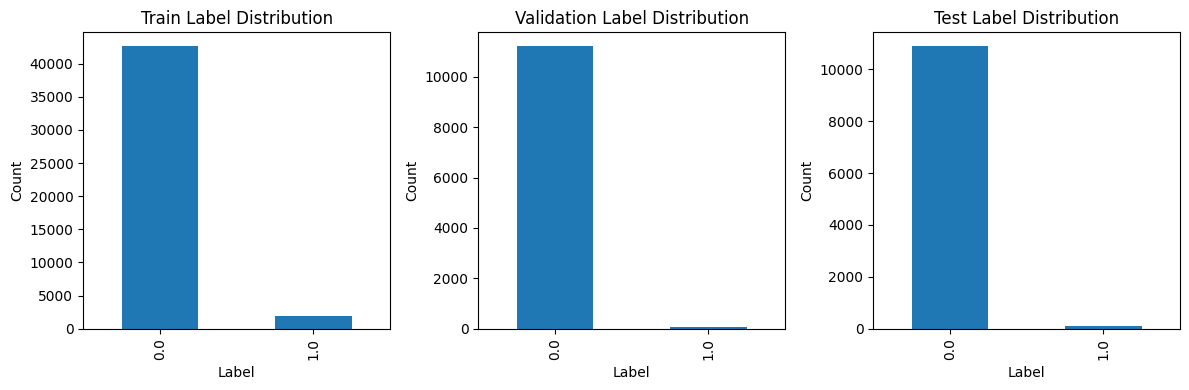

In [35]:
import matplotlib.pyplot as plt

# 計算各資料集的標籤分佈
train_counts = pd.Series(train_ds.y.numpy()).value_counts()
val_counts   = pd.Series(val_ds.y.numpy()).value_counts()
test_counts  = pd.Series(test_ds.y.numpy()).value_counts()

# 畫圖
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, counts, title in zip(
    axes,
    [train_counts, val_counts, test_counts],
    ["Train", "Validation", "Test"]
):
    counts.plot(kind='bar', ax=ax)
    ax.set_title(f"{title} Label Distribution")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [36]:
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# 取出標籤（假設 train_ds.y 是 0/1 的 torch.tensor）
y = train_ds.y.cpu().numpy()
assert set(np.unique(y)).issubset({0,1}), "train_ds 應只有 0/1 標籤"

num_pos = int((y == 1).sum())
num_neg = int((y == 0).sum())
p_target = 0.15 # 你可以之後調 0.2~0.35

# 權重：讓期望抽樣比例 ≈ p_target
w_pos = p_target / max(num_pos, 1)
w_neg = (1.0 - p_target) / max(num_neg, 1)
sample_weights = np.where(y == 1, w_pos, w_neg).astype(np.float64)
sample_weights = torch.from_numpy(sample_weights)

balanced_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # 每個 epoch 跑滿步數
    replacement=True
)

In [ ]:
train_loader = DataLoader(
    train_ds,
    batch_size=512,         # 或你的 GPU 極限
    #sampler=balanced_sampler,
    shuffle=True,  # 如果不使用 sampler，則需要 shuffle
    num_workers=8,
    pin_memory=True,
    drop_last=True
)
# For evaluation, no shuffle
train_loader_eval = DataLoader(
    train_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True
)

val_loader = DataLoader(val_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)

## Train Model

In [38]:
from src.model import FocalLoss, CNNLSTMModel
from torch.optim import AdamW

model = CNNLSTMModel(
    num_features=len(extended_feature_cols),
    cnn_out_channels=32,   # 32 → 64
    lstm_hidden_size=64,  # 64 → 128
    lstm_layers=2,         # 1 → 2
    dropout=0.5
)

criterion = FocalLoss(alpha=0.75, gamma=2.0)
# 如果改用 BCE：
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.2], device=device))

optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

In [39]:
import math

steps_per_epoch = len(train_loader)
max_epochs = 30
total_steps = steps_per_epoch * max_epochs
warmup_steps = max(1, int(total_steps * 0.05))

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
    return 0.1 + 0.9 * cosine  # 下界 0.1×

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [ ]:

log = train_loop(
    model, train_loader, val_loader, 
    log_interval=25, 
    num_epochs=10, 
    optimizer=optimizer, 
    criterion=criterion,
    scheduler=scheduler,
    save_interval=1,
    #save_path='model/0814_0457'
)

In [ ]:
#log = pd.read_csv('model/0813_1935/training_log.csv')

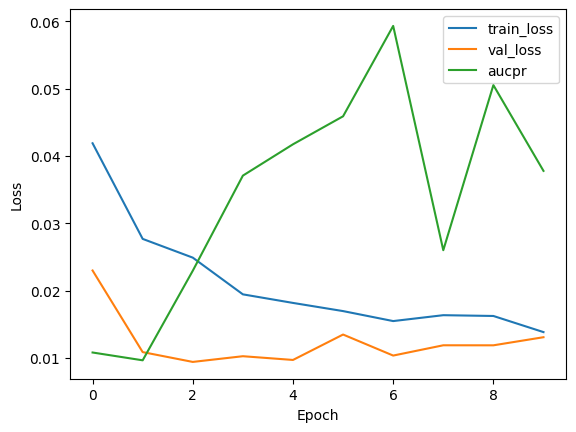

In [ ]:
visualize_log(log)

### Model Evaluation

In [41]:
model.load_state_dict(torch.load(r'model\0814_2150\best_model.pth', weights_only=True))

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



<All keys matched successfully>

In [ ]:
train_trues, train_outputs, train_loss= test_loop(model, train_loader_eval, criterion=criterion)

Testing: 100%|██████████| 44/44 [00:09<00:00,  4.64it/s]


Performance on Training Set:
Train Loss: 0.014527602645102888
              precision    recall  f1-score   support

      Normal       0.99      0.89      0.94     42584
     Failure       0.26      0.86      0.40      1920

    accuracy                           0.89     44504
   macro avg       0.63      0.87      0.67     44504
weighted avg       0.96      0.89      0.92     44504

[[37974  4610]
 [  277  1643]]
ROC AUC: 0.9380


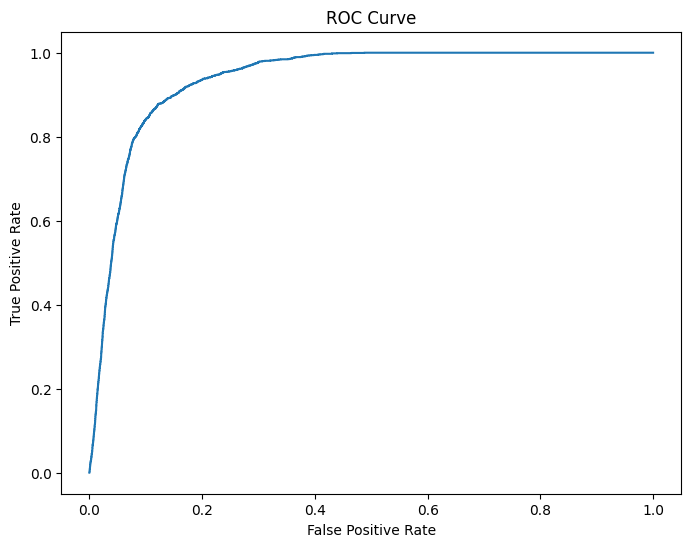

In [46]:
train_predictions = (train_outputs > 0.35).astype(int)

print("Performance on Training Set:")
print("Train Loss:", train_loss)

generate_report(train_trues, train_predictions, train_outputs)

In [ ]:
from sklearn.linear_model import LogisticRegression
from src.train import get_logits_and_labels

val_logits, val_labels = get_logits_and_labels(model, val_loader)
test_logits, test_labels = get_logits_and_labels(model, test_loader)
val_scores = torch.sigmoid(torch.tensor(val_logits)).numpy()
test_scores = torch.sigmoid(torch.tensor(test_logits)).numpy()

# === 2. Platt scaling (logistic regression) ===
platt = LogisticRegression(solver='lbfgs', class_weight='balanced')
platt.fit(val_logits.reshape(-1, 1), val_labels)  # 強調正樣本
pickle.dump(platt, open("model/platt_scaler.pkl", "wb"))

# === 3. 校準分數 ===
val_probs_calibrated = platt.predict_proba(val_logits.reshape(-1, 1))[:, 1]
test_probs_calibrated = platt.predict_proba(test_logits.reshape(-1, 1))[:, 1]

# === 4. 在 val 上找最佳門檻 ===
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(val_labels, val_probs_calibrated)

target_recall = 0.8
best_idx = next(i for i,r in enumerate(recall) if r < target_recall) - 1
best_threshold = thresholds[best_idx]
print(f"Threshold for recall ≥ {target_recall}: {best_threshold:.4f}, Precision={precision[best_idx]:.3f}")

# === 5. 在 test set 上套用門檻 ===
test_preds = (test_probs_calibrated >= best_threshold).astype(int)
val_preds = (val_probs_calibrated >= best_threshold).astype(int)

Threshold for recall ≥ 0.8: 0.8720, Precision=0.050


Performance on Validation Set:
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96     11210
     Failure       0.05      0.80      0.09        60

    accuracy                           0.92     11270
   macro avg       0.52      0.86      0.53     11270
weighted avg       0.99      0.92      0.95     11270

[[10299   911]
 [   12    48]]
ROC AUC: 0.9535


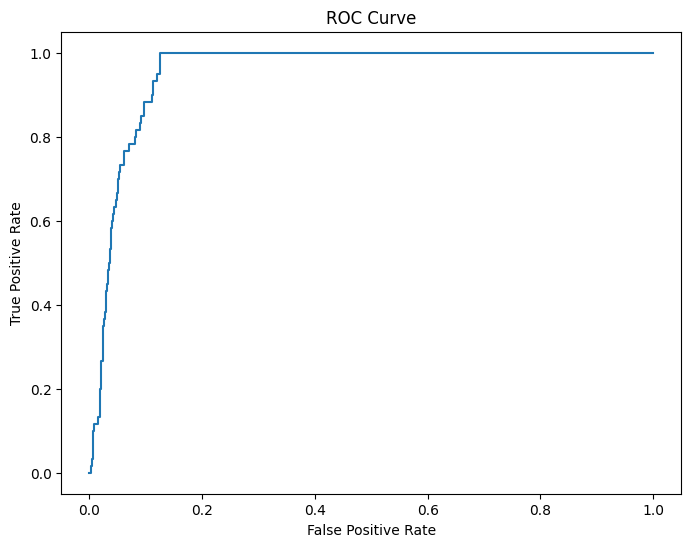

In [50]:
print("Performance on Validation Set:")
generate_report(val_labels, val_preds, val_probs_calibrated,)